In [1]:
import netCDF4 as nc
import numpy as np
import xarray as xr
import warnings
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import gridspec
import datetime
import seaborn as sns
import cmocean as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.stats import linregress
import matplotlib.patches as mpatches
import scipy.io as sio
import matplotlib.colors as mcolors
import matplotlib.patches as patch
import sys
import os
sys.path.append(os.path.abspath('../scripts'))
from proj_utils import *
fig_path      = '../figures'

# Pull Mass Flux Data, Subset and Mask

In [2]:
s3, credentials = init_S3FileSystem(use_earthdata=False, requester_pays=True)
mzz_local_directory = Path('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native')

In [3]:
mzz_local_file= mzz_local_directory / 'OCEAN_VOLUME_FLUX_mon_mean_native_llc090_ECCOV4r5.json' # Pull monthly velocity 
fs = fsspec.filesystem("reference",     
                       fo=str(mzz_local_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
# 
fs.asynchronous = True
store = zarr.storage.FsspecStore(fs)
ds = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':4, 'Z':50})

In [4]:
bathy_path = user_home_dir + '/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc'
ds_bathy   = xr.open_dataset(bathy_path).Depth
ds_geom    = xr.open_dataset(bathy_path)

In [5]:
ds_vel_north  = proc_dataset(ds, face = 'north')
ds_geom_north = proc_dataset(ds_geom, face = 'north')

ds_vel_east  = proc_dataset(ds, face = 'east')
ds_geom_east = proc_dataset(ds_geom, face = 'east')

# Flux Calculation

In [6]:
# --- Flux NORTH FACE ---
u    = ds_vel_north['UVELMASS'].squeeze()
hfac = ds_geom_north['hFacW'].squeeze()
dy   = ds_geom_north['dyC'].squeeze()
drf  = ds_geom_north['drF'].squeeze()

In [7]:
drf_3d = drf.broadcast_like(u)
dx_3d  = dy.broadcast_like(u)

In [8]:
area = dx_3d * drf_3d * hfac

In [9]:
flux_north = (u * area).sum(dim=['k', 'j']).sel(j_g=72).squeeze()

In [10]:
# --- Flux EAST FACE ---
v    = ds_vel_east['VVELMASS'].squeeze()
hfac = ds_geom_east['hFacS'].squeeze()
dx   = ds_geom_east['dxC'].squeeze()
drf  = ds_geom_east['drF'].squeeze()

In [11]:
drf_3d = drf.broadcast_like(v)
dx_3d  = dy.broadcast_like(v)

In [12]:
area = dx_3d * drf_3d * hfac
flux_east = (v * area).sum(dim=['k', 'i']).sel(j_g=72).squeeze()

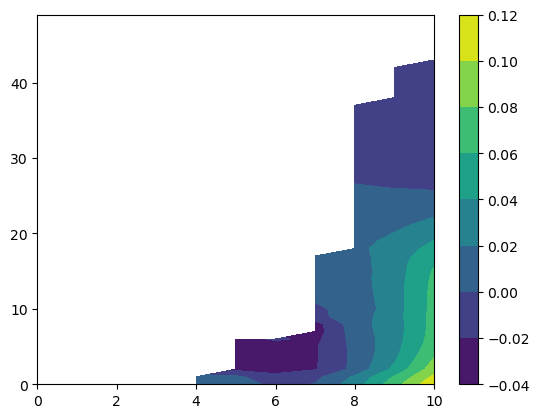

In [14]:
plt.contourf(ds_vel_east.VVELMASS[20,:,:])
plt.colorbar()

# Plot Resulting Time Series

In [14]:
# --- Load files into memory for faster computations --- 
flux_north = flux_north.load()
flux_east  = flux_east.load()

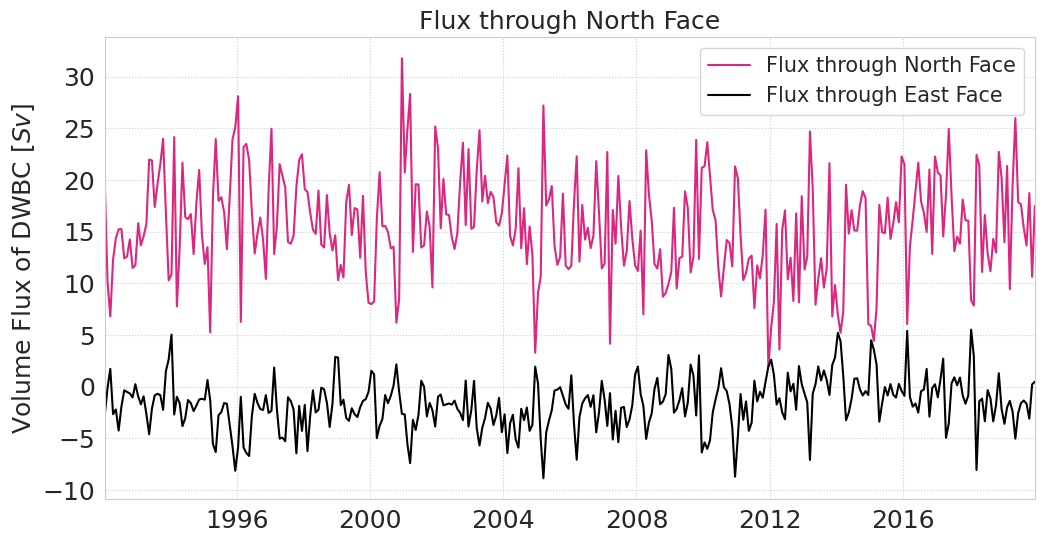

In [15]:
sv_name = '/north_face_flux_ts'
sns.set_style('whitegrid',{"grid.linestyle": ":"})
fig     = plt.figure(figsize=(12, 6))

north_face  = plt.plot(flux_north.time,flux_north/1e6, c = '#dc267f', label = 'Flux through North Face')
east_face  = plt.plot(flux_east.time,flux_east/1e6, c = 'k', label = 'Flux through East Face')

#mean_flux   = plt.axhline(flux_north.mean(dim='time').compute()/1e6, color = 'k', linestyle = '--', linewidth = 2)
xtix = plt.yticks(fontsize=18)
xtix = plt.xticks(fontsize=18)

plt.xlim(flux_north.time[0],flux_north.time[-1])
plt.title('Flux through North Face',  fontsize = 18)
plt.legend(fontsize=15)
plt.ylabel('Volume Flux of DWBC [$Sv$]',fontsize = 18 )
plt.savefig(fig_path + sv_name + '.png', format='png', bbox_inches="tight",dpi=500)